In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fastai.vision.all import * 
import torch
import kaggle
import zipfile
from torchvision import datasets, transforms

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Already ran the following code to download and extract the data:

"""!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri
with zipfile.ZipFile('brain-tumor-classification-mri.zip', 'r') as zip_ref:
    zip_ref.extractall('.')"""

"!kaggle datasets download -d sartajbhuvaji/brain-tumor-classification-mri\nwith zipfile.ZipFile('brain-tumor-classification-mri.zip', 'r') as zip_ref:\n    zip_ref.extractall('.')"

In [4]:
train_path = Path("./Training/")
test_path = Path("./Testing/")

train_transform = transforms.Compose([
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(10), # 10-degree random rotation
    #transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    #transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(root=train_path, transform=train_transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)

test_data = datasets.ImageFolder(root=test_path, transform=test_transform)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4)

In [5]:
label = [k for k in test_data.class_to_idx]
label

['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

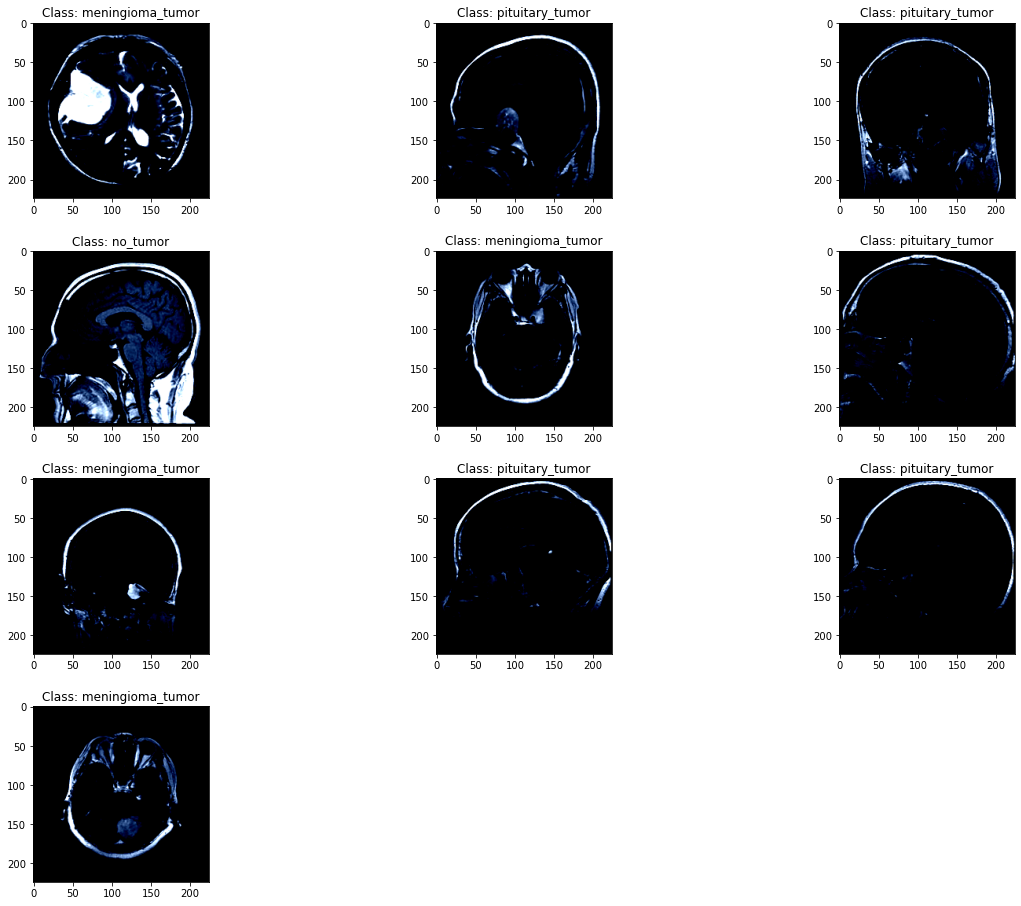

In [6]:
label= train_data.classes

images, titles = next(iter(train_loader))

images = images.numpy()
titles = titles.numpy()

plt.figure(figsize=(20,20))

for i in range(10):
    plt.subplot(5,3,i+1)
    plt.subplots_adjust(hspace=.3,wspace=.3)
    plt.imshow(np.transpose(images[i],(1,2,0)))
    plt.title(F'Class: {label[titles[i]]}')

In [7]:
# Recreating the Tiny VGG architecture

class tiny_vgg(nn.Module):
  
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 56 * 56, out_features=output_shape)  # Note: You might need to adjust the "56*56" depending on your input size.
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [8]:
model = tiny_vgg(input_shape=3, hidden_units=20, output_shape=len(label))
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=.01)
num_epochs = 10

In [9]:
# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

c:\Users\Justin\anaconda3\envs\dev\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 1/10, Loss: 1.2898, Accuracy: 39.13%
Epoch 2/10, Loss: 1.0632, Accuracy: 56.06%
Epoch 3/10, Loss: 0.8465, Accuracy: 65.75%
Epoch 4/10, Loss: 0.7432, Accuracy: 70.87%
Epoch 5/10, Loss: 0.6794, Accuracy: 73.76%
Epoch 6/10, Loss: 0.6915, Accuracy: 75.05%
Epoch 7/10, Loss: 0.6001, Accuracy: 77.21%
Epoch 8/10, Loss: 0.5606, Accuracy: 79.13%
Epoch 9/10, Loss: 0.5278, Accuracy: 80.28%
Epoch 10/10, Loss: 0.5040, Accuracy: 81.53%


In [10]:
# Test Predictions:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for i, (x,y) in enumerate(test_loader):
        x,y = x.to(device), y.to(device)
        preds = model(x)
        _, predicted = preds.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()
    
    print(f"Accuracy: {100 * correct / total:.2f}%")

Accuracy: 58.63%


In [11]:
import torch.nn as nn
import torch.nn.functional as F

def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=4):  # Adjusted num_classes to 4 for your problem
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self.make_layer(block, 64, layers[0])
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def resnet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])  # ResNet-18

In [12]:
model = resnet18()
model.to(device)  # If using GPU
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=.01)
num_epochs = 10

In [13]:
# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%")

Epoch 1/10, Loss: 0.9632, Accuracy: 59.69%
Epoch 2/10, Loss: 0.6426, Accuracy: 74.22%
Epoch 3/10, Loss: 0.4676, Accuracy: 82.79%
Epoch 4/10, Loss: 0.3388, Accuracy: 88.22%
Epoch 5/10, Loss: 0.2301, Accuracy: 92.75%
Epoch 6/10, Loss: 0.1702, Accuracy: 94.67%
Epoch 7/10, Loss: 0.0627, Accuracy: 99.02%
Epoch 8/10, Loss: 0.0263, Accuracy: 99.79%
Epoch 9/10, Loss: 0.0129, Accuracy: 100.00%
Epoch 10/10, Loss: 0.0068, Accuracy: 100.00%


In [14]:
# Test Predictions:
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for i, (x,y) in enumerate(test_loader):
        x,y = x.to(device), y.to(device)
        preds = model(x)
        _, predicted = preds.max(1)
        total += y.size(0)
        correct += predicted.eq(y).sum().item()
    
    print(f"Accuracy: {100 * correct / total:.2f}%")

Accuracy: 73.86%


In [15]:
from fastai.vision.augment import aug_transforms

tumor = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(.1),
    get_y = parent_label,
    item_tfms = Resize(224),
    #batch_tfms = augments
).dataloaders(train_path, bs=64)

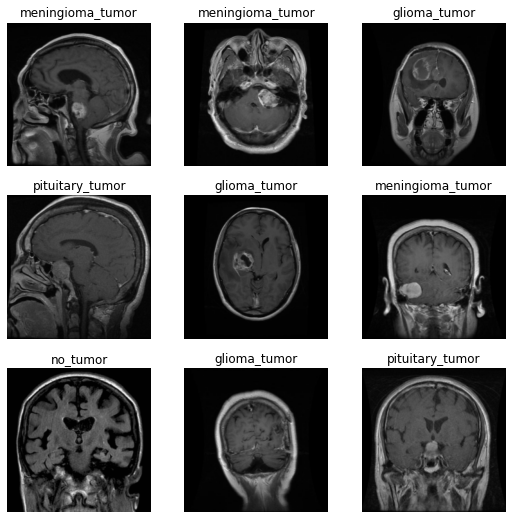

In [16]:
tumor.show_batch()

In [17]:
learn = vision_learner(tumor, resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to C:\Users\Justin/.cache\torch\hub\checkpoints\resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [18]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.186563,0.823813,0.749129,00:23


epoch,train_loss,valid_loss,accuracy,time
0,0.439289,0.238062,0.912892,00:24
1,0.274798,0.241759,0.933798,00:23
2,0.152971,0.116304,0.961672,00:24
3,0.086247,0.077212,0.968641,00:24
4,0.044598,0.083306,0.975610,00:23


In [19]:
preds, targets = learn.get_preds(dl=test_loader)
acc = accuracy(preds, targets).item()
print(F"Accuracy: {(100*acc):.2f}%")

Accuracy: 75.89%
